[*********************100%***********************]  10 of 10 completed


Portfolio Weights:
BTC-USD         0.0000
SUI20947-USD    0.3185
XAUT-USD        0.0000
TON11419-USD    0.1732
UNI-USD         0.1270
LTC-USD         0.1079
GLM-USD         0.0963
BNB-USD         0.0824
NEAR-USD        0.0485
USDT-USD        0.0462
dtype: float64

Portfolio Performance Metrics:
Cumulative Return: 89.59%
Standard Deviation: 69.03%
Beta (BTC): 0.9605
Beta (GOLD): 1.0084
VaR 95%: -4.92%
VaR 99%: -9.97%
CVaR 95%: -7.35%
CVaR 99%: -10.72%
Maximum Drawdown: -48.32%
Sharpe Ratio: 1.4872
Treynor Ratio (BTC): 0.0559
Treynor Ratio (GOLD): 0.0533
Jensen's Alpha (BTC): 0.0012
Jensen's Alpha (GOLD): 0.0020
Sortino Ratio: 0.0067
Information Ratio: 0.9088
Tracking Error: 45.10%
R-squared (BTC): 0.5743
R-squared (GOLD): 0.0442
Upside Capture: 1.0251
Downside Capture: 0.9113
Omega Ratio: 1.2648
Calmar Ratio: 2.2697
Tail Risk (Expected Shortfall): -7.35%
Diversification Ratio: 1.4684


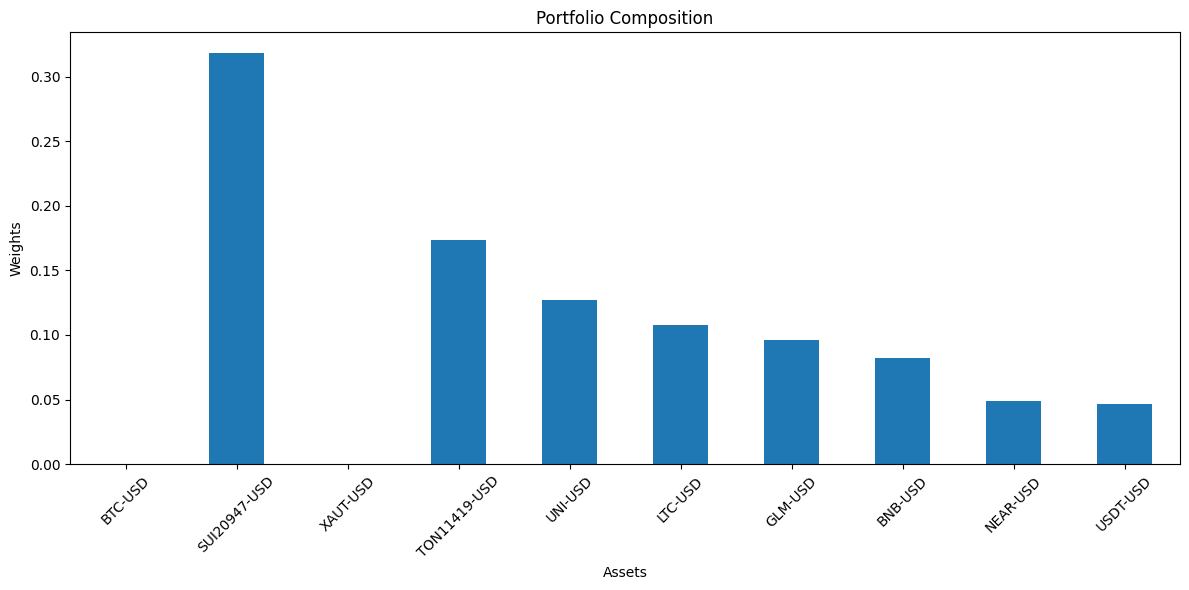

<Figure size 2400x1000 with 0 Axes>

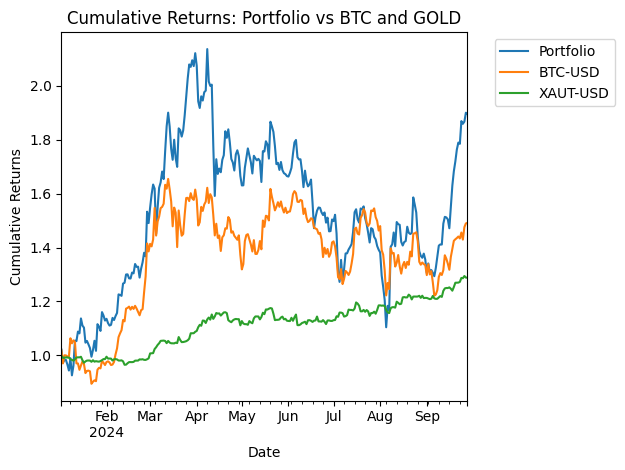

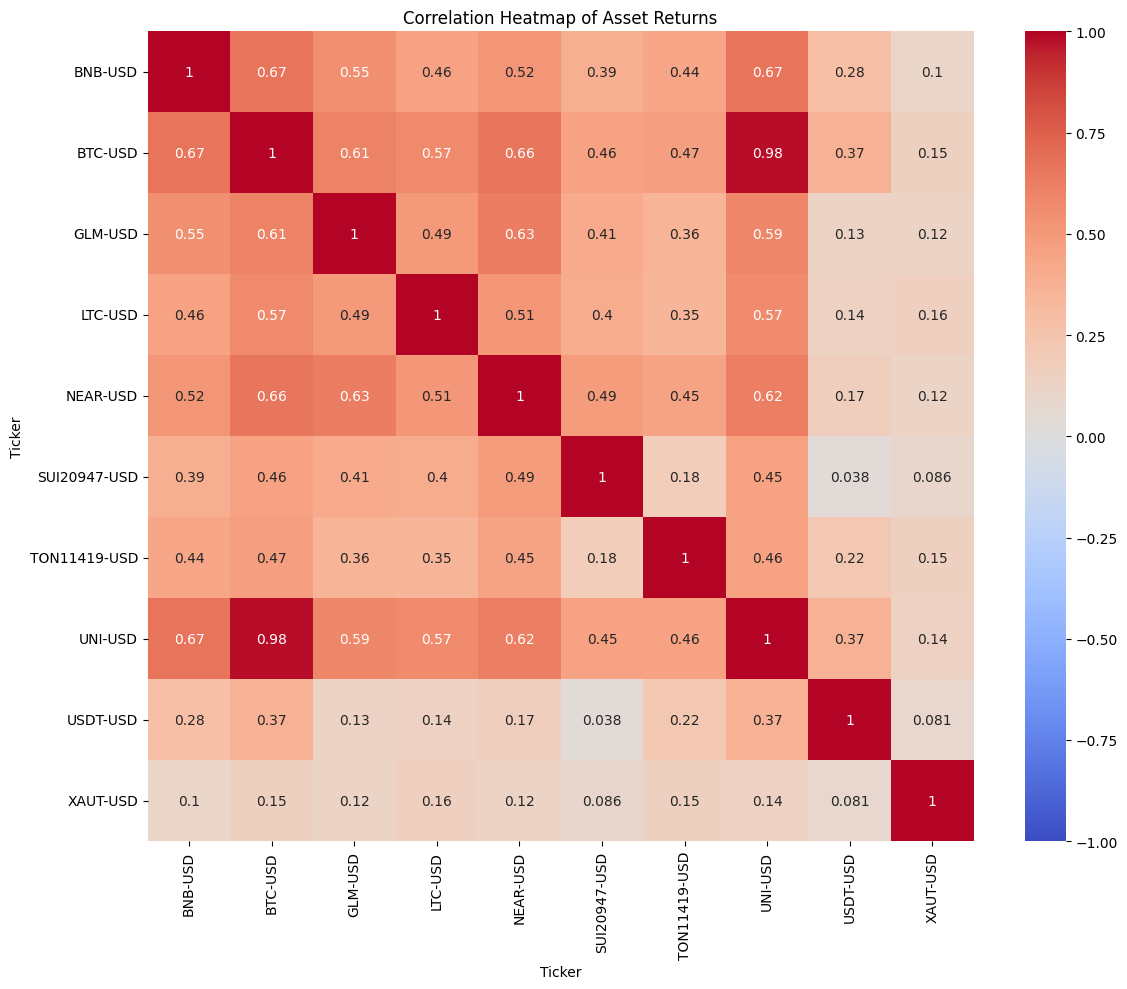

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def download_crypto_data(assets, start_date, end_date):
    data = yf.download(assets, start=start_date, end=end_date)
    return data['Adj Close']

def calculate_returns(data):
    return data.pct_change().dropna()

def calculate_portfolio_return(returns, weights):
    return (returns * weights).sum(axis=1)

def calculate_performance_metrics(returns, weights, rf_rate):
    portfolio_return = calculate_portfolio_return(returns, weights)
    btc_returns = returns['BTC-USD']
    gold_returns = returns['XAUT-USD']

    # Cumulative return
    portfolio_cumulative_return = (1 + portfolio_return).cumprod().iloc[-1] - 1

    # Standard deviation
    std_dev = portfolio_return.std() * np.sqrt(365)

    # Beta
    beta_btc = np.cov(portfolio_return, btc_returns)[0, 1] / np.var(btc_returns)
    beta_gold = np.cov(portfolio_return, gold_returns)[0, 1] / np.var(gold_returns)

    # VaR and CVaR
    var_95 = np.percentile(portfolio_return, 5)
    var_99 = np.percentile(portfolio_return, 1)
    cvar_95 = portfolio_return[portfolio_return <= var_95].mean()
    cvar_99 = portfolio_return[portfolio_return <= var_99].mean()

    # Maximum drawdown
    cum_returns = (1 + portfolio_return).cumprod()
    max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()

    # Sharpe ratio
    sharpe_ratio = (portfolio_return.mean() - rf_rate) / portfolio_return.std() * np.sqrt(365)

    # Treynor ratio
    treynor_ratio_btc = (portfolio_return.mean() - rf_rate) / beta_btc * np.sqrt(365)
    treynor_ratio_gold = (portfolio_return.mean() - rf_rate) / beta_gold * np.sqrt(365)

    # Jensen's alpha
    market_return_btc = btc_returns.mean()
    market_return_gold = gold_returns.mean()
    jensen_alpha_btc = portfolio_return.mean() - (rf_rate + beta_btc * (market_return_btc - rf_rate))
    jensen_alpha_gold = portfolio_return.mean() - (rf_rate + beta_gold * (market_return_gold - rf_rate))

    # Sortino ratio
    downside_returns = portfolio_return[portfolio_return < 0]
    sortino_ratio = (portfolio_return.mean() - rf_rate) / (downside_returns.std() * np.sqrt(365))

    # Information ratio and tracking error
    excess_return = portfolio_return - btc_returns
    information_ratio = excess_return.mean() / excess_return.std() * np.sqrt(365)
    tracking_error = excess_return.std() * np.sqrt(365)

    # R-squared
    r_squared_btc = np.corrcoef(portfolio_return, btc_returns)[0, 1]**2
    r_squared_gold = np.corrcoef(portfolio_return, gold_returns)[0, 1]**2

    # Upside/downside capture
    up_market = btc_returns > 0
    down_market = btc_returns < 0
    upside_capture = (portfolio_return[up_market].mean() / btc_returns[up_market].mean())
    downside_capture = (portfolio_return[down_market].mean() / btc_returns[down_market].mean())

    # Omega ratio
    threshold = rf_rate
    omega_ratio = (portfolio_return[portfolio_return > threshold].sum() /
                   abs(portfolio_return[portfolio_return < threshold].sum()))

    # Calmar ratio
    calmar_ratio = (portfolio_return.mean() * 365) / abs(max_drawdown)

    # Tail risk (Expected Shortfall)
    tail_risk = cvar_95

    # Diversification ratio
    weighted_volatility = (weights * returns.std()).sum()
    portfolio_volatility = portfolio_return.std()
    diversification_ratio = weighted_volatility / portfolio_volatility

    metrics = {
        'Cumulative Return': portfolio_cumulative_return,
        'Standard Deviation': std_dev,
        'Beta (BTC)': beta_btc,
        'Beta (GOLD)': beta_gold,
        'VaR 95%': var_95,
        'VaR 99%': var_99,
        'CVaR 95%': cvar_95,
        'CVaR 99%': cvar_99,
        'Maximum Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Treynor Ratio (BTC)': treynor_ratio_btc,
        'Treynor Ratio (GOLD)': treynor_ratio_gold,
        'Jensen\'s Alpha (BTC)': jensen_alpha_btc,
        'Jensen\'s Alpha (GOLD)': jensen_alpha_gold,
        'Sortino Ratio': sortino_ratio,
        'Information Ratio': information_ratio,
        'Tracking Error': tracking_error,
        'R-squared (BTC)': r_squared_btc,
        'R-squared (GOLD)': r_squared_gold,
        'Upside Capture': upside_capture,
        'Downside Capture': downside_capture,
        'Omega Ratio': omega_ratio,
        'Calmar Ratio': calmar_ratio,
        'Tail Risk (Expected Shortfall)': tail_risk,
        'Diversification Ratio': diversification_ratio
    }

    return pd.Series(metrics)


def plot_portfolio_composition(weights):
    plt.figure(figsize=(12, 6))
    weights.plot(kind='bar')
    plt.title('Portfolio Composition')
    plt.xlabel('Assets')
    plt.ylabel('Weights')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_cumulative_returns(portfolio_returns, asset_returns, weights):
    plt.figure(figsize=(24, 10))
    cumulative_returns = (1 + asset_returns).cumprod()
    cumulative_returns['Portfolio'] = (1 + portfolio_returns).cumprod()

    # Only plot assets with non-zero weights
    assets_to_plot = ['Portfolio'] + [asset for asset, weight in weights.items() if weight > 0]
    cumulative_returns[['Portfolio', 'BTC-USD', 'XAUT-USD']].plot()
    plt.title('Cumulative Returns: Portfolio vs BTC and GOLD')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



def plot_correlation_heatmap(returns):
    plt.figure(figsize=(12, 10))
    sns.heatmap(returns.corr('spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Asset Returns')
    plt.tight_layout()
    plt.show()

def main():
    # Define assets and their weights
    assets = {
        'BTC-USD': 0.0,
        'SUI20947-USD': 0.3185,
        'XAUT-USD': 0.0,
        'TON11419-USD': 0.1732,
        'UNI-USD': 0.127,
        'LTC-USD': 0.1079,
        'GLM-USD': 0.0963,
        'BNB-USD': 0.0824,
        'NEAR-USD': 0.0485,
        'USDT-USD': 0.0462
    }

    # Set date range
    start_date = '2024-01-01'
    end_date = '2024-09-29'

    # Download data and calculate returns
    data = download_crypto_data(list(assets.keys()), start_date, end_date)
    returns = calculate_returns(data)

    # Create weights series
    weights = pd.Series(assets)

    # Calculate portfolio returns
    portfolio_returns = calculate_portfolio_return(returns, weights)

    # Calculate performance metrics
    rf_rate = 0.07 / 365  # Assuming 7% annual risk-free rate, converted to daily
    metrics = calculate_performance_metrics(returns, weights, rf_rate)

    # Print results
    print("Portfolio Weights:")
    print(weights)
    print("\nPortfolio Performance Metrics:")

    # Format and print metrics
    for metric, value in metrics.items():
        if metric in ['Cumulative Return', 'Standard Deviation', 'VaR 95%', 'VaR 99%',
                      'CVaR 95%', 'CVaR 99%', 'Maximum Drawdown', 'Tracking Error',
                      'Tail Risk (Expected Shortfall)']:
            print(f"{metric}: {value:.2%}")
        elif metric in ['Beta (BTC)', 'Beta (GOLD)', 'R-squared (BTC)', 'R-squared (GOLD)',
                        'Upside Capture', 'Downside Capture']:
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value:.4f}")

    # Generate plots
    plot_portfolio_composition(weights)
    plot_cumulative_returns(portfolio_returns, returns, weights)
    plot_correlation_heatmap(returns)

if __name__ == "__main__":
    main()

[*********************100%***********************]  10 of 10 completed



Portfolio Performance Metrics:
Cumulative Return: 89.59%
Standard Deviation: 69.03%
Beta (BTC): 0.9605
Beta (GOLD): 1.0084
VaR 95%: -4.92%
VaR 99%: -9.97%
CVaR 95%: -7.35%
CVaR 99%: -10.72%
Maximum Drawdown: -48.32%
Sharpe Ratio: 1.4872
Sortino Ratio: 0.0067
Treynor Ratio (BTC): 0.0559
Treynor Ratio (GOLD): 0.0533
Jensen's Alpha (BTC): -0.6566
Jensen's Alpha (GOLD): -0.3517
Information Ratio: -1.5162
Tracking Error: 0.4510
R-squared (BTC): 0.5743
R-squared (GOLD): 0.0442
Upside Capture: 1.3631
Downside Capture: 1.1149
Omega Ratio: 1.2648
Calmar Ratio: 2.2697
Tail Risk (Expected Shortfall): -0.1072
Diversification Ratio: 1.1216


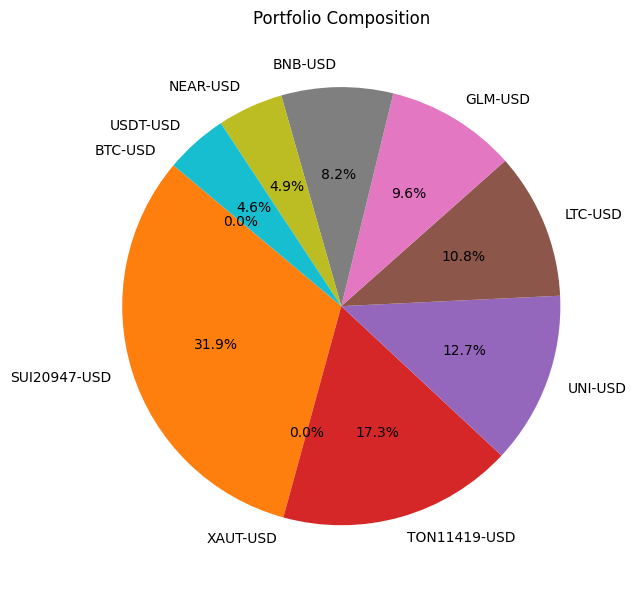

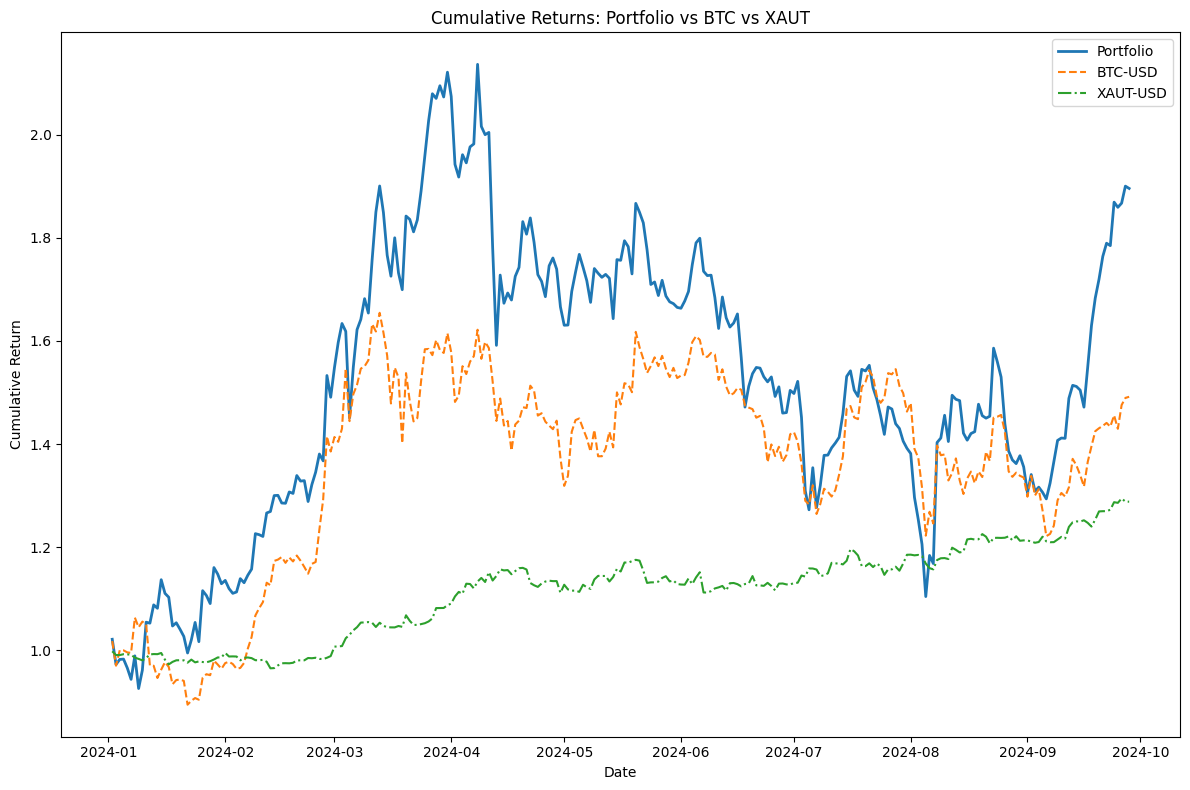

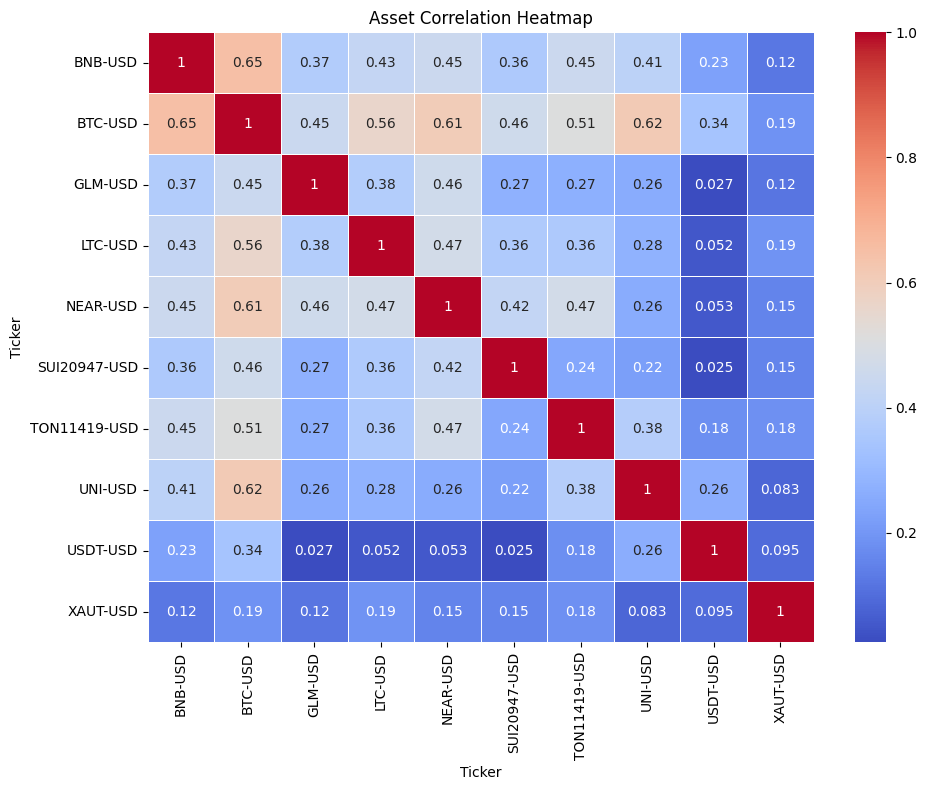

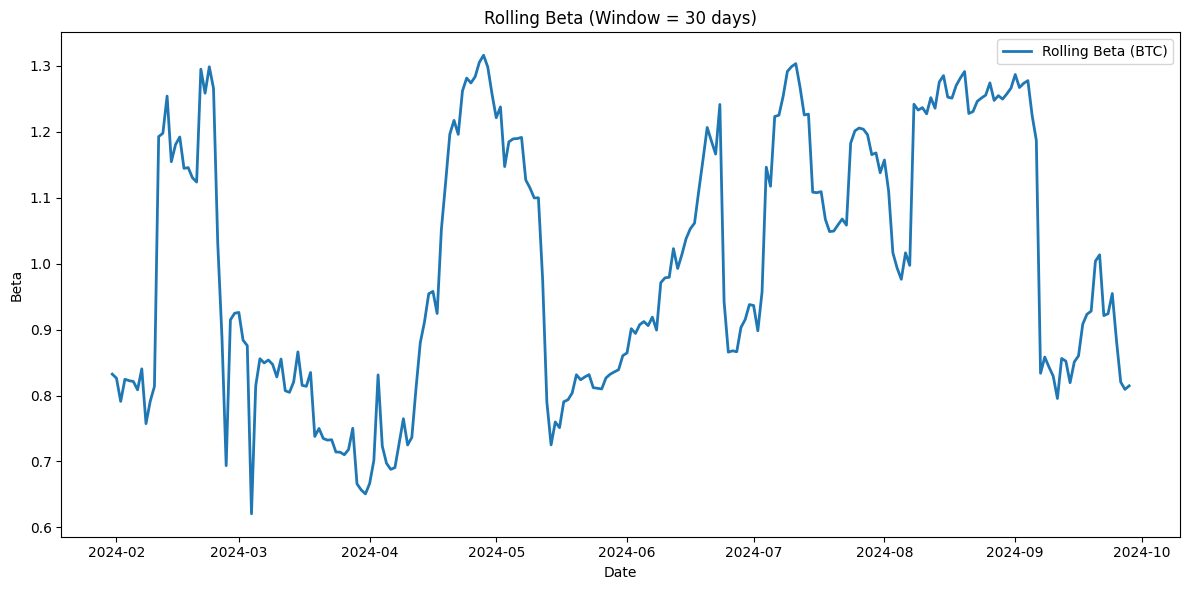

In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced Portfolio Analysis

Refactored version for improved modularity, performance metrics, and analysis power.
"""

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define the Portfolio class
class Portfolio:
    def __init__(self, assets, weights, start_date, end_date, rf_rate):
        """
        Initialize the Portfolio object.

        Parameters:
        assets (dict): Dictionary of assets and their weights.
        weights (list): List containing asset weights.
        start_date (str): Start date for data download.
        end_date (str): End date for data download.
        rf_rate (float): Risk-free rate (annual).
        """
        self.assets = assets
        self.weights = pd.Series(weights, index=assets.keys())
        self.start_date = start_date
        self.end_date = end_date
        self.rf_rate = rf_rate / 365  # Convert annual risk-free rate to daily rate
        self.data = None
        self.returns = None
        self.portfolio_return = None

    def download_data(self):
        """Download historical adjusted closing prices for the given assets."""
        self.data = yf.download(list(self.assets.keys()), start=self.start_date, end=self.end_date)['Adj Close']

    def calculate_returns(self):
        """Calculate daily returns for the downloaded asset data."""
        self.returns = self.data.pct_change().dropna()

    def calculate_portfolio_return(self):
        """Calculate daily portfolio return based on asset returns and weights."""
        self.weights /= self.weights.sum()  # Normalize weights to sum to 1
        self.portfolio_return = (self.returns * self.weights).sum(axis=1)

    def calculate_performance_metrics(self):
        """Calculate various performance metrics for the portfolio."""
        if self.portfolio_return is None:
            raise ValueError("Portfolio return not calculated. Run calculate_portfolio_return() first.")

        btc_returns = self.returns['BTC-USD']
        gold_returns = self.returns['XAUT-USD']

        # Cumulative return
        portfolio_cumulative_return = (1 + self.portfolio_return).cumprod().iloc[-1] - 1

        # Standard deviation
        std_dev = self.portfolio_return.std() * np.sqrt(365)

        # Beta
        beta_btc = np.cov(self.portfolio_return, btc_returns)[0, 1] / np.var(btc_returns)
        beta_gold = np.cov(self.portfolio_return, gold_returns)[0, 1] / np.var(gold_returns)

        # Value at Risk (VaR) and Conditional Value at Risk (CVaR)
        var_95 = np.percentile(self.portfolio_return, 5)
        var_99 = np.percentile(self.portfolio_return, 1)
        cvar_95 = self.portfolio_return[self.portfolio_return <= var_95].mean()
        cvar_99 = self.portfolio_return[self.portfolio_return <= var_99].mean()

        # Maximum drawdown
        cum_returns = (1 + self.portfolio_return).cumprod()
        max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()

        # Sharpe ratio
        sharpe_ratio = (self.portfolio_return.mean() - self.rf_rate) / self.portfolio_return.std() * np.sqrt(365)

        # Sortino ratio
        downside_deviation = self.portfolio_return[self.portfolio_return < 0].std() * np.sqrt(365)
        sortino_ratio = (self.portfolio_return.mean() - self.rf_rate) / downside_deviation

        # Treynor ratio
        treynor_ratio_btc = (self.portfolio_return.mean() - self.rf_rate) / beta_btc * np.sqrt(365)
        treynor_ratio_gold = (self.portfolio_return.mean() - self.rf_rate) / beta_gold * np.sqrt(365)

        # Jensen's alpha
        market_return_btc = btc_returns.mean() * 365
        market_return_gold = gold_returns.mean() * 365
        jensens_alpha_btc = (self.portfolio_return.mean() - self.rf_rate) - beta_btc * (market_return_btc - self.rf_rate)
        jensens_alpha_gold = (self.portfolio_return.mean() - self.rf_rate) - beta_gold * (market_return_gold - self.rf_rate)

        # Information ratio
        tracking_error = (self.portfolio_return - btc_returns).std() * np.sqrt(365)
        information_ratio = (self.portfolio_return.mean() - market_return_btc) / tracking_error

        # R-squared
        r_squared_btc = np.corrcoef(self.portfolio_return, btc_returns)[0, 1] ** 2
        r_squared_gold = np.corrcoef(self.portfolio_return, gold_returns)[0, 1] ** 2

        # Upside and Downside Capture
        upside_capture = self.portfolio_return[self.portfolio_return > 0].mean() / btc_returns[btc_returns > 0].mean()
        downside_capture = self.portfolio_return[self.portfolio_return < 0].mean() / btc_returns[btc_returns < 0].mean()

        # Omega ratio
        threshold = 0
        gains = self.portfolio_return[self.portfolio_return > threshold].sum()
        losses = -self.portfolio_return[self.portfolio_return < threshold].sum()
        omega_ratio = gains / losses

        # Calmar ratio
        calmar_ratio = self.portfolio_return.mean() * 365 / abs(max_drawdown)

        # Tail Risk (Expected Shortfall)
        tail_risk = cvar_99

        # Diversification Ratio
        weighted_volatility = np.dot(self.weights, self.returns.std())
        portfolio_volatility = self.portfolio_return.std()
        diversification_ratio = weighted_volatility / portfolio_volatility

        metrics = {
            'Cumulative Return': portfolio_cumulative_return,
            'Standard Deviation': std_dev,
            'Beta (BTC)': beta_btc,
            'Beta (GOLD)': beta_gold,
            'VaR 95%': var_95,
            'VaR 99%': var_99,
            'CVaR 95%': cvar_95,
            'CVaR 99%': cvar_99,
            'Maximum Drawdown': max_drawdown,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Treynor Ratio (BTC)': treynor_ratio_btc,
            'Treynor Ratio (GOLD)': treynor_ratio_gold,
            "Jensen's Alpha (BTC)": jensens_alpha_btc,
            "Jensen's Alpha (GOLD)": jensens_alpha_gold,
            'Information Ratio': information_ratio,
            'Tracking Error': tracking_error,
            'R-squared (BTC)': r_squared_btc,
            'R-squared (GOLD)': r_squared_gold,
            'Upside Capture': upside_capture,
            'Downside Capture': downside_capture,
            'Omega Ratio': omega_ratio,
            'Calmar Ratio': calmar_ratio,
            'Tail Risk (Expected Shortfall)': tail_risk,
            'Diversification Ratio': diversification_ratio
        }
        return metrics

    def plot_portfolio_composition(self):
        """Plot the composition of the portfolio."""
        plt.figure(figsize=(10, 6))
        plt.pie(self.weights, labels=self.assets.keys(), autopct='%1.1f%%', startangle=140)
        plt.title('Portfolio Composition')
        plt.tight_layout()
        plt.show()

    def plot_cumulative_returns(self):
        """Plot the cumulative returns of the portfolio and individual assets."""
        plt.figure(figsize=(12, 8))
        cumulative_portfolio_returns = (1 + self.portfolio_return).cumprod()
        plt.plot(cumulative_portfolio_returns, label='Portfolio', linewidth=2)
        plt.plot((1 + self.returns['BTC-USD']).cumprod(), label='BTC-USD', linestyle='--')
        plt.plot((1 + self.returns['XAUT-USD']).cumprod(), label='XAUT-USD', linestyle='-.')
        plt.title('Cumulative Returns: Portfolio vs BTC vs XAUT')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self):
        """Plot the correlation heatmap of asset returns."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.returns.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Asset Correlation Heatmap')
        plt.tight_layout()
        plt.show()

    def rolling_beta(self, window=30):
        """Calculate and plot rolling beta of the portfolio against BTC."""
        rolling_cov = self.portfolio_return.rolling(window).cov(self.returns['BTC-USD'])
        rolling_var = self.returns['BTC-USD'].rolling(window).var()
        rolling_beta = rolling_cov / rolling_var
        rolling_beta = rolling_beta.dropna()  # Drop NaN values to ensure proper plotting

        plt.figure(figsize=(12, 6))
        if not rolling_beta.empty:
            plt.plot(rolling_beta, label='Rolling Beta (BTC)', linewidth=2)
        else:
            print("No rolling beta values available for the specified window.")
        plt.title(f'Rolling Beta (Window = {window} days)')
        plt.xlabel('Date')
        plt.ylabel('Beta')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def run_full_analysis(self):
        """Run the entire portfolio analysis process."""
        self.download_data()
        self.calculate_returns()
        self.calculate_portfolio_return()
        metrics = self.calculate_performance_metrics()
        # Print performance metrics
        print("\nPortfolio Performance Metrics:")
        for metric, value in metrics.items():
            if metric in [
                'Cumulative Return', 'Standard Deviation', 'VaR 95%', 'VaR 99%',
                'CVaR 95%', 'CVaR 99%', 'Maximum Drawdown'
            ]:
                print(f"{metric}: {value:.2%}")
            else:
                print(f"{metric}: {value:.4f}")
        # Generate plots
        self.plot_portfolio_composition()
        self.plot_cumulative_returns()
        self.plot_correlation_heatmap()
        self.rolling_beta()

# Main function to run the analysis
def main():
    # Define assets and their weights
    assets = {
        'BTC-USD': 0.0,
        'SUI20947-USD': 0.3185,
        'XAUT-USD': 0.0,
        'TON11419-USD': 0.1732,
        'UNI-USD': 0.127,
        'LTC-USD': 0.1079,
        'GLM-USD': 0.0963,
        'BNB-USD': 0.0824,
        'NEAR-USD': 0.0485,
        'USDT-USD': 0.0462
    }
    start_date = '2024-01-01'
    end_date = '2024-09-29'
    rf_rate = 0.07  # Annual risk-free rate

    # Create a Portfolio object and run the analysis
    portfolio = Portfolio(assets=assets, weights=list(assets.values()), start_date=start_date, end_date=end_date, rf_rate=rf_rate)
    portfolio.run_full_analysis()

if __name__ == "__main__":
    main()